# Visualizing Neural network approximations to functions

### Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import altair as alt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/My Drive/Images'

Mounted at /content/drive


### Auxiliary functions

In [ ]:
# Plots ReLU components of the last layer of a fully connected NN
def ReLU_components_plotter(model,x,scaler_x=None,scaler_y=None,ymin=0):  
  L = len(model.layers)
  H = model.layers[-1].weights[0].shape[0]
  if scaler_x:
    X = scaler_x.transform(x)
  else:
    X = x
  Y = np.empty([H, len(X)])
  for l in range(L):
    W = model.layers[l].weights[0].numpy()
    B = model.layers[l].bias.numpy()
    if l < L-1:
      B = B[None,:]
      #print(X.shape)
      #print(W.shape)
      #print(b.shape)
      #print('*---*')
      X = tf.nn.relu(X@W + B)
    else: # Final layer
      #print(X.shape)
      #print(W.shape)
      #print(b.shape)
      #print('*---*')
      for f in range(H): #ReLU components
        y = X[:,f]*W[f]
        y = y.numpy().reshape(-1,1)
        if scaler_y:
          y = scaler_y.inverse_transform(y)
        Y[f] = y.squeeze()-ymin
      Z = X@W+B
      if scaler_y:
        B = scale_y.inverse_transform(B.reshape(-1,1))
        Z = scale_y.inverse_transform(Z)
      return Y,B,Z

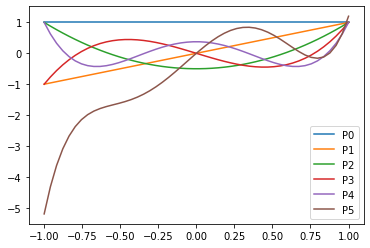

In [ ]:
def Legendre_polynomials(n):
    a = 1
    b = 0
    c = 0
    if n==0:
            return lambda x: np.ones(len(x)) + c
    elif n==1:
            return lambda x: x + c
    elif n==2:
            return lambda x: (1/2)*(3*(x-b)**2-1) + c
    elif n==3:
            return lambda x: (1/2)*(5*(x-b)**3-3*x) + c
    elif n==4:
            return lambda x: (1/8)*(35*(a*x-b)**4-30*(a*x-b)**2+3) + c
    elif n==5:
            return lambda x: 1.2*(1/8)*(63*x**5-70*x**3+15*x) + 2*x - 2*x**2
    elif n==6:
            return lambda x: (1/16)*(231*x**6-315*x**4+105*x**2-5) + c
    elif n==7:
            return lambda x: (1/16)*(429*x**7-693*x**5+315*x**3-35*x) + c
    elif n==8:
            return lambda x: (1/128)*(6435*x**8-12012*x**6+6930*x**4-1260*x**2+35) + c
    elif n==9:
            return lambda x: (1/128)*(12155*x**9-25740*x**7+18018*x**5-4620*x**3+315*x) + c
    elif n==10:
            return lambda x: (1/256)*(46189*x**10-109395*x**8+90090*x**6-30030*x**4+3465*x**2-63) + c
    else:
        raise ValueError(f'n must be leq than 10')

def GaussianNoise(mu=0,sigma=0.5):
    return lambda x: np.random.normal(mu, sigma,len(x))
            
def function(base,noise):
    return lambda x: base(x) + noise(x)
    
N = 5

x_poli = np.linspace(-1,1,num=50)
for n in range(N+1):
    Poli = Legendre_polynomials(n)
    y_poli = Poli(x_poli)
    plt.plot(x_poli,y_poli,label = f'P{n}')
plt.legend();

### Preliminaries

### Ploting the original function

In [ ]:
np.random.seed(0) # Set seed for numpy

mu = 0.
sigma = 0.15

func = function(Legendre_polynomials(N),GaussianNoise(mu,sigma))
y_noise = func(x_poli)

#plt.plot(x,Legendre_polynomials(N)(x),label = f'P{N}',color='black')
#plt.plot(x,y_noise, label = f'P{N} with noise', color='blue')
#plt.legend();

df = pd.DataFrame({'x': np.concatenate((x_poli,x_poli)), 'y': np.concatenate((y_poli,y_noise)), 'Function': ['Original']*len(x_poli)+['Noisy']*len(x_poli)})
alt.Chart(df).mark_line().encode(
    x='x',
    y='y',
    color=alt.Color('Function',
                   scale=alt.Scale(
            domain=['Original', 'Noisy'],
            range=['black', 'orange']))).mark_line(size=2)

alt.Chart(...)


### Sampling training and test data

In [ ]:
n_data_points = 200

# Generate training points
x = np.linspace(-1, 1, num=n_data_points)
y = func(x)

# Split training and test set
mask = (np.arange(len(x)) % 5) >0 # 20% test set
x_train = x[mask]
x_test = x[~mask]
y_train = y[mask] 
y_test = y[~mask]

# Sort values for plotting
sort_train = np.argsort(x_train)
x_train = x_train[sort_train]
y_train = y_train[sort_train]

sort_test = np.argsort(x_test)
x_test = x_test[sort_test]
y_test = y_test[sort_test]

Test_MSE = dict()

poly_features = PolynomialFeatures(degree=10)

# Extend data with colums with the new features
x_train_poly = poly_features.fit_transform(x_train.reshape(-1,1))
x_test_poly = poly_features.fit_transform(x_test.reshape(-1,1))

In [ ]:
d = {'x': np.concatenate((x_train,x_test)), 'y': np.concatenate((y_train,y_test)), 'Data': ['Train']*len(x_train)+['Test']*len(x_test)}
df = pd.DataFrame(data=d)
line = alt.Chart(pd.DataFrame({'x':x_poli,'y': y_poli,'Data': len(x_poli)*['Original']})).mark_line().encode(
      x='x',y='y',color=alt.value("#002474"))
scatter = alt.Chart(df).mark_circle(size=20).encode(
      x='x',
      y='y',
      color='Data',
      tooltip=['x','y']
      ).interactive()

line + scatter

alt.LayerChart(...)

## Solving the problem with linear regression on polynomial features

prediction =  -0.654x^0
Loss: 1.852
Test Mean Square Error: 2.019 

prediction =  -0.664x^0 + 2x^1
Loss: 0.5111
Test Mean Square Error: 0.6317 

prediction =  0.0116x^0 + 2.02x^1 + -2.01x^2
Loss: 0.1461
Test Mean Square Error: 0.1573 

prediction =  0.0121x^0 + 1.9x^1 + -2.01x^2 + 0.185x^3
Loss: 0.1453
Test Mean Square Error: 0.1542 

prediction =  0.016x^0 + 1.9x^1 + -2.05x^2 + 0.184x^3 + 0.045x^4
Loss: 0.1453
Test Mean Square Error: 0.1549 

prediction =  0.00497x^0 + 4.11x^1 + -1.9x^2 + -10x^3 + -0.184x^4 + 9.11x^5
Loss: 0.01913
Test Mean Square Error: 0.02095 

prediction =  -0.013x^0 + 4.1x^1 + -1.52x^2 + -10x^3 + -1.3x^4 + 9.08x^5 + 0.815x^6
Loss: 0.01887
Test Mean Square Error: 0.02083 



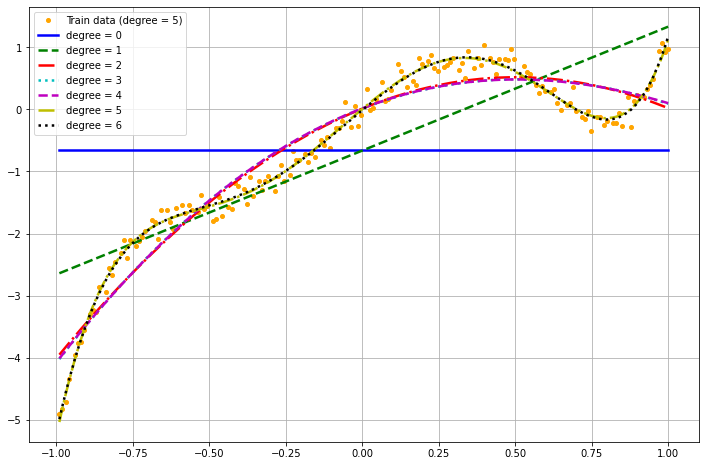

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(x_train,y_train,label=f'Train data (degree = {N})',color='orange', 
         marker='o', linestyle='dashed',linewidth=0,markersize=4)
ls=['-','--','-.',':','--','-.',':']
color=['b','g','r','c','m','y','k']
for d in range(N+2):

    linear_model = LinearRegression(fit_intercept=False)
    linear_model = linear_model.fit(x_train_poly[:,:d+1].reshape(-1,d+1), y_train)
    
    result = 'prediction = '
    for n,c in enumerate(linear_model.coef_):
        result = result + f' {linear_model.coef_[n]:.3g}x^{n} +'
    print(result[:-2].format(linear_model.coef_))

    y_pred_train = linear_model.predict(x_train_poly[:,:d+1].reshape(-1,d+1))
    loss = mean_squared_error(y_train,y_pred_train)
    print(f'Loss: {loss:.4g}')

    y_pred_test = linear_model.predict(x_test_poly[:,:d+1].reshape(-1,d+1))
    test_MSE = mean_squared_error(y_test,y_pred_test)

    Test_MSE['Linear ' + str(d)] = test_MSE
    print(f'Test Mean Square Error: {test_MSE:.4g} \n')

    y_pred = linear_model.predict(x_train_poly[:,:d+1].reshape(-1,d+1))
    plt.plot(x_train,y_pred,label=f'degree = {d}', linewidth=2.5, linestyle=ls[d], color=color[d])
plt.grid(True)
plt.legend()
plt.savefig(f"{images_dir}/Polynomial_approximations.png")
plt.show()

There is no overfitting with order 6 due to the high number of data points

## Solving the problem with a Neural Network

### Common parameters for all models

In [ ]:
ini = 'he_uniform'

ini1 = tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
ini_bias1 = tf.random_uniform_initializer(minval=0.05, maxval=0.2)

ini2 = tf.random_normal_initializer(mean=0.3, stddev=0.05)
ini_bias2 = tf.random_uniform_initializer(minval=0.5, maxval=1)

loss = 'mse'

# optimizer = tf.keras.optimizers.SGD(lr=1e-1)
# optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='mse', min_delta=0.0005, patience=50, verbose=True, mode='auto',
    baseline=None, restore_best_weights=True
)
verbose = 0
epochs = 500

### Model with a single node: Recover (unique) linear solution

In [ ]:
model0 = tf.keras.Sequential([
         tf.keras.layers.Dense(1, activation='linear', name='fc1', input_dim=1)
            ])
model0.summary()

model0.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


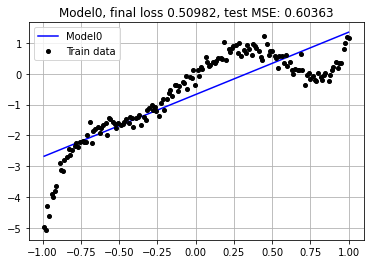

In [ ]:
history0 = model0.fit(x_train.reshape(-1,1), y_train.reshape(-1,1),
                      epochs=epochs,
                      batch_size=round(x_train.shape[0]/50),
                      verbose=verbose)
    
y_pred = model0.predict(x_train.reshape(-1,1))
    
plt.plot(x_train,y_pred,label = 'Model0', c='blue')
plt.plot(x_train,y_train,label = 'Train data',color='black', 
         marker='o', linestyle='dashed',linewidth=0,markersize=4)
#plt.plot(x_test, y_test, '.', markersize=4, color='blue', label = 'Test data')


final_loss = history0.history['loss'][-1]
y_test_pred = model0.predict(x_test)
test_MSE = mean_squared_error(y_test,y_test_pred)
plt.title(f'Model0, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
plt.grid(True)
plt.legend()
plt.savefig(f"{images_dir}/Model0.png")

In [ ]:
Test_MSE['Model0'] = test_MSE

In [ ]:
# parameters of the resulting fit
a = model0.get_weights()[0][0,0]
b = model0.get_weights()[1][0]

In [ ]:
print(f'prediction = {b:.3g} + {a:.3g}x')
print(f'Test Mean Square Error: {test_MSE:.4g}')

prediction = -0.676 + 2.02x
Test Mean Square Error: 0.6036


#### Plotting the loss surface

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

def f(m,b):
    yhat = x_train*m+b
    return np.mean((y_train - yhat) ** 2)

mmin,mmax,bmin,bmax = 1.25,3,-1.2,0

nm = 300
nb = 300
u = np.linspace(mmin, mmax, nm) 
v = np.linspace(bmin, bmax, nb)

xx = np.zeros((nm,nb),dtype='d')
yy = np.zeros((nm,nb),dtype='d')
zz = np.zeros((nm,nb),dtype='d')

# populate x,y,z arrays
for i in range(nm):
    for j in range(nb):
        xx[i,j] = u[i]
        yy[i,j] = v[j]
        zz[i,j] = min(f(xx[i,j],yy[i,j]),3)

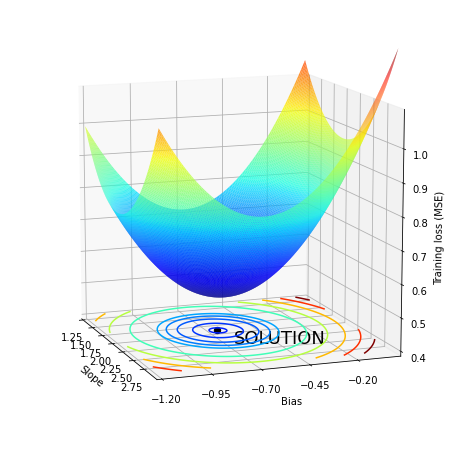

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

# Plot the 3D surface
ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, alpha=0.8,cmap=cm.jet)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
cset = ax.contour(xx, yy, zz, zdir='MSE', offset=0.4, cmap=cm.jet, levels=[0.4,0.45,0.475,0.5,0.51125,0.525,0.55,0.575,0.6,0.7,0.8,0.9,1.0,1.1])

ax.set_xlim(mmin, mmax)
ax.xaxis.set_ticks(np.arange(mmin, mmax, 0.25))

ax.set_ylim(bmin, bmax)
ax.yaxis.set_ticks(np.arange(bmin, bmax, 0.25))

ax.set_zlim(0.5, 1.1)
ax.zaxis.set_ticks(np.arange(0.4, 1.1, 0.1))

ax.set_xlabel('Slope')
ax.set_ylabel('Bias')
ax.set_zlabel('Training loss (MSE)')

ax.view_init(elev=12., azim=-20)

# Obtained solution
ax.scatter(a, b, zs=0.40, zdir='z', c='k', s=40, marker = 'o')
ax.text(1.2*a, 1.02*b, 0.40, s='SOLUTION', fontsize=18)
fig.savefig(f"{images_dir}/LossSurface.png")

### Model with one hidden layer with a single node

loss =  0.5100175142288208, seed = 24878946
loss =  1.8908946514129639, seed = 83276171
loss =  1.8909263610839844, seed = 94746231
loss =  0.509623646736145, seed = 1758485


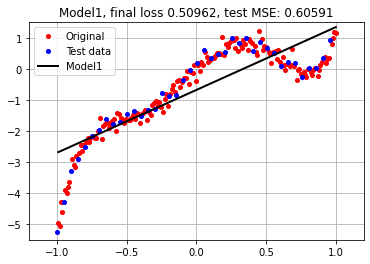

In [ ]:
while True:
  nn = 1
  seed = np.random.randint(0,1e8)
  tf.random.set_seed(seed)

  optimizer1 = tf.keras.optimizers.Adam(lr=1e-3)

  model1 = tf.keras.Sequential([
      tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                            kernel_initializer = ini2),
      tf.keras.layers.Dense(1)
                      ])

  model1.compile(optimizer=optimizer,
              loss=loss,
              metrics=['mse'])

  history1 = model1.fit(x_train.reshape(-1,1), y_train.reshape(-1,1),
                epochs=epochs,
                callbacks=[],
                batch_size=round(x_train.shape[0]/20),
                verbose=verbose)

  y_pred = model1.predict(x_train.reshape(-1,1))
  final_loss = history1.history['loss'][-1]
  print(f'loss =  {final_loss}, seed = {seed}')

  if final_loss < 0.51:
      y_pred = model1.predict(x_train.reshape(-1,1))

      y_test_pred = model1.predict(x_test)
      test_MSE = mean_squared_error(y_test,y_test_pred)

      plt.title(f'Model1, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
      plt.plot(x_train,y_train,label = 'Original',color='red', 
              marker='o', linestyle='dashed', linewidth=0, markersize=4)
      plt.plot(x_test,y_test,label = 'Test data',color='b', 
              marker='o', linestyle='dashed', linewidth=0, markersize=4)

      plt.plot(x_train,y_pred,label = 'Model1', c ='k',linewidth=2)
      plt.legend()
      plt.grid()
      plt.axis((-1.2,1.2,-5.5,1.5))
      plt.savefig(f"{images_dir}/Model1.png")
      plt.show()
      break

The resulting fit is still a linear approximation. Even though the model is able to represent a single ReLU function, it chose not to use it since it would not result in a lower loss.

In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1)                 2         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


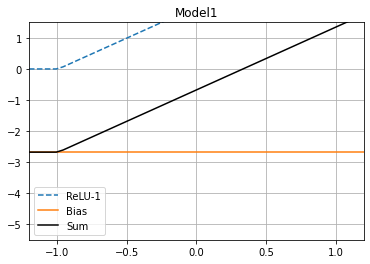

In [ ]:
X = np.linspace(-1.2, 1.2, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model1,X)
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model1')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model1_decomp.png")
plt.show()

It can be seen how te value of the single ReLU has its singularity just outside of the range of values under consideration

In [ ]:
Test_MSE['Model1'] = test_MSE
# Error is much lower 
# Remember that this is Mean square error, so that the values are
# comparable even though the points are different

### Scale the input and output variables and create dataloaders

In [ ]:
print(x_train.min(), x_train.max(), y_train.min(), y_train.max())

scale_x = MinMaxScaler()
x_train_scaled = scale_x.fit_transform(x_train.reshape(-1,1))
scale_y = MinMaxScaler()
y_train_scaled = scale_y.fit_transform(y_train.reshape(-1,1))

x_test_scaled = scale_x.transform(x_test.reshape(-1,1))  # Note: not fit_transform
y_test_scaled = scale_y.transform(y_test.reshape(-1,1))  # Note: not fit_transform

print(x_train_scaled.min(), x_train_scaled.max(), y_train_scaled.min(), y_train_scaled.max())

-0.9899497487437185 1.0 -4.907239294335332 1.0643060913364797
0.0 0.9999999999999999 0.0 0.9999999999999999


We create a dataset object to feed it to the model. It is important to shuffle the data since it was created in a very strict order which could introduce
biases in the training of the model.
Also relevant is the fact that batch size should be less than the length whole dataset. Even though it is possible to run a full gradient on the whole dataset due to the small size of the problem, it is usually less efficient than stochastic gradient descent (it doesn't take advantage of data redundancy) and it can get stuck in worse local minima.

In [ ]:
# Batch size is really important! Full GD fails to find a good minimum and SGD
# usually works faster and finds a better minimum
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_scaled))
train_dataset = train_dataset.shuffle(buffer_size=10).batch(10)

### Model with one hidden layer with 2 nodes.

loss =  0.004186463542282581, seed = 61856360
loss =  0.01343597937375307, seed = 96490108
loss =  0.0037691928446292877, seed = 65198271
loss =  0.004174941219389439, seed = 29745472
loss =  0.013248762115836143, seed = 88959475
loss =  0.00382225145585835, seed = 93322712
loss =  0.004275972954928875, seed = 48320892
loss =  0.013280555605888367, seed = 86380791
loss =  0.013379372656345367, seed = 8353717
loss =  0.013347163796424866, seed = 95075828
loss =  0.013536563143134117, seed = 58629809
loss =  0.0037442415487021208, seed = 7721291
loss =  0.013800437562167645, seed = 28572463
loss =  0.013386559672653675, seed = 4874384
loss =  0.0024315346963703632, seed = 64080038


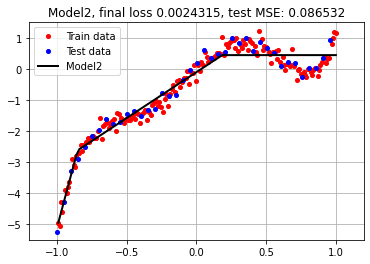

In [ ]:
# This model includes previous model, so minimum should be lower. However, depends on training
while True: # Loop over different seeds
    nn = 2
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    model2 = tf.keras.Sequential([
                tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                tf.keras.layers.Dense(1, activation='linear', name='fc2', 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias2),
                ])

    model2.compile(optimizer=optimizer,
                       loss=loss,
                       metrics=['mse'])

    history2 = model2.fit(train_dataset,
                          epochs=2*epochs,
                          callbacks=[],
                          verbose=verbose)

    # batch size is really important! Full GD fails to find better minimum
    final_loss = history2.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
    if final_loss < 0.0025: # Stop when a good solution is found
        
        y_pred_scaled = model2.predict(x_train_scaled)
        y_test_scaled = model2.predict(x_test_scaled)

        # Reverse the scaling
        y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
        y_test_pred = scale_y.inverse_transform(y_test_scaled)

        test_MSE = mean_squared_error(y_test,y_test_pred)

        plt.title(f'Model2, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
        plt.plot(x_train,y_train,label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)
        plt.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)

        plt.plot(x_train,y_plot_pred,label = 'Model2', c ='k', linewidth=2)
        plt.legend()
        plt.grid()
        plt.axis((-1.2,1.2,-5.5,1.5))
        plt.savefig(f"{images_dir}/Model2.png")
        plt.show()
        break

The neural net correctly places the two ReLU function that it can represent to better approximate the left side, which minimizes MSE. The right side is fit using a constant approximation,since there are no more ReLU components available to produce a better fit. It takes several tries to find this solution however, as the method seems to quickly converge to non-optimal minima.

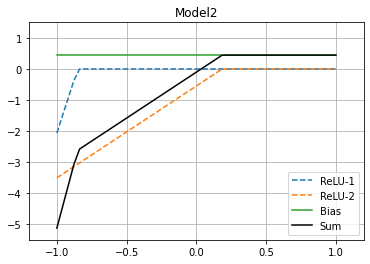

In [ ]:
X = np.linspace(-1, 1, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model2,X,scale_x,scale_y,y_train.min())
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model2')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model2_decomp.png")
plt.show()

In [ ]:
model2.summary()
model2.get_weights()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 2)                 4         
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


[array([[-2.8275847, -1.4533799]], dtype=float32),
 array([0.19777136, 0.8584225 ], dtype=float32),
 array([[-1.5475655],
        [-0.6441272]], dtype=float32),
 array([0.876395], dtype=float32)]

In [ ]:
Test_MSE['Model2'] = test_MSE

### Model with one hidden layer with 3 nodes

loss =  0.0074202218092978, seed = 68455938
loss =  0.007463020272552967, seed = 79583998
loss =  0.003758807899430394, seed = 47237703
loss =  0.013218577019870281, seed = 88225573
loss =  0.003750049974769354, seed = 97566986
loss =  0.004187968093901873, seed = 40647123
loss =  0.01336968969553709, seed = 95520822
loss =  0.004195329733192921, seed = 36630156
loss =  0.013378007337450981, seed = 78023172
loss =  0.01313868723809719, seed = 26640320
loss =  0.013491019606590271, seed = 53216735
loss =  0.003774612443521619, seed = 75751270
loss =  0.013181215152144432, seed = 35555018
loss =  0.007662190590053797, seed = 71822705
loss =  0.013505332171916962, seed = 88267135
loss =  0.003755162935703993, seed = 53241192
loss =  0.048053331673145294, seed = 46042126
loss =  0.013264278881251812, seed = 14431301
loss =  0.0073503716848790646, seed = 77288923
loss =  0.04805389791727066, seed = 64665605
loss =  0.013303672894835472, seed = 26969056
loss =  0.0037455055862665176, seed = 

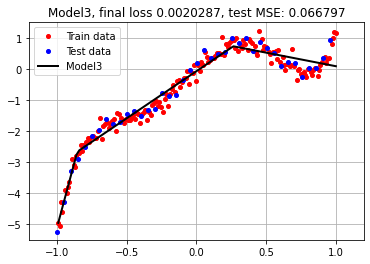

In [ ]:
while True: # Loop over different seeds
    nn = 3
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    model3 = tf.keras.Sequential([
                tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini),
                tf.keras.layers.Dense(1, activation='linear', name='out', 
                                      kernel_initializer = ini,
                                      bias_initializer=ini),
                ])

    model3.compile(optimizer=optimizer,
                       loss=loss,
                       metrics=['mse'])

    history3 = model3.fit(train_dataset,
                          epochs=5*epochs,
                          callbacks=[],
                          verbose=verbose)


    final_loss = history3.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
    if final_loss < 0.0021: # Stop when a good solution is found
        
        y_pred_scaled = model3.predict(x_train_scaled)
        y_test_scaled = model3.predict(x_test_scaled)

        # Reverse the scaling
        y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
        y_test_pred = scale_y.inverse_transform(y_test_scaled)

        test_MSE = mean_squared_error(y_test,y_test_pred)

        plt.title(f'Model3, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
        plt.plot(x_train,y_train,label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)
        plt.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)

        plt.plot(x_train,y_plot_pred,label = 'Model3', c ='k', linewidth=2)
        plt.legend()
        plt.grid()
        plt.axis((-1.2,1.2,-5.5,1.5))
        plt.savefig(f"{images_dir}/Model3.png")
        plt.show()
        break

Many different initializations were needed to obtain a solution superior to the previous one.
Three ReLU components provide a pretty good structure for the approximating function to give good results.

In [ ]:
X = np.linspace(-1, 1, num=50).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model3,X,scale_x,scale_y,y_train.min())
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model3')
plt.axis((-1.2,1.2,-5.5,1.5))
plt.savefig(f"{images_dir}/Model3_decomp.png")
plt.show()

In [ ]:
Test_MSE['Model3'] = test_MSE

### Model with one hidden layer with 10 nodes

loss =  0.0020508128218352795, seed = 31333996
loss =  0.00206350302323699, seed = 16277332
loss =  0.00173373450525105, seed = 40790343
loss =  0.002063362393528223, seed = 82010707
loss =  0.0016640570247545838, seed = 15141120
loss =  0.0007375181885436177, seed = 40469611
Loss criteria satisfied


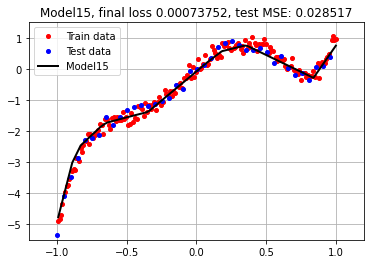

In [ ]:
while True: # Loop over different seeds
    nn = 15
    seed = np.random.randint(0,1e8)
    tf.random.set_seed(seed)    

    model15 = tf.keras.Sequential([
                tf.keras.layers.Dense(nn, activation='relu', name='fc1', input_dim=1, 
                                      kernel_initializer = ini,
                                      bias_initializer=ini_bias1),
                tf.keras.layers.Dense(1, activation='linear', name='out', input_dim=nn, 
                                      kernel_initializer = ini1,
                                      bias_initializer=ini_bias1),
                ])

    model15.compile(optimizer=optimizer,
                       loss=loss,
                       metrics=['mse'])

    history15 = model15.fit(train_dataset,
                          epochs=10*epochs,
                          callbacks=[],
                          verbose=verbose)


    final_loss = history15.history['loss'][-1]
    print(f'loss =  {final_loss}, seed = {seed}')
    
    if final_loss < 0.00095: # Stop when a good solution is found
        print('Loss criteria satisfied')
        y_pred_scaled = model15.predict(x_train_scaled)
        y_test_scaled = model15.predict(x_test_scaled)

        # Reverse the scaling
        y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
        y_test_pred = scale_y.inverse_transform(y_test_scaled)

        test_MSE = mean_squared_error(y_test,y_test_pred)

        plt.title(f'Model15, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
        plt.plot(x_train,y_train,label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)
        plt.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=4)

        plt.plot(x_train,y_plot_pred,label = 'Model15', c ='k', linewidth=2)
        plt.legend()
        plt.grid()
        plt.axis((-1.2,1.2,-5.5,1.5))
        plt.savefig(f"{images_dir}/Model15.png")
        plt.show()
        break

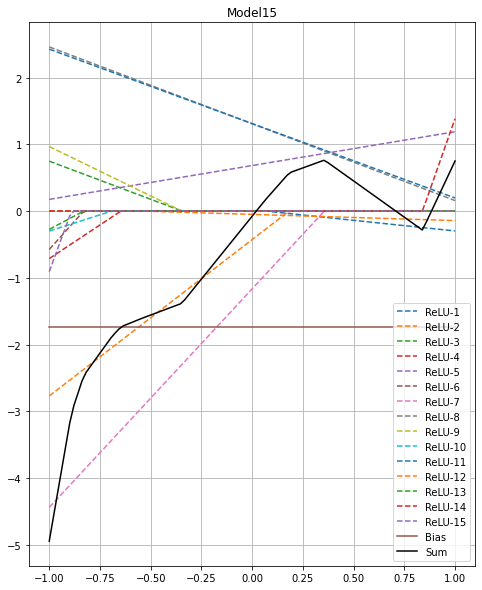

In [ ]:
X = np.linspace(-1, 1, num=100).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model15,X,scale_x,scale_y,y_train.min())
plt.figure(figsize=(8,10))
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model15')
plt.savefig(f"{images_dir}/Model15_decomp.png")
plt.show()

In [ ]:
model15.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 15)                30        
_________________________________________________________________
out (Dense)                  (None, 1)                 16        
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Test_MSE['Model15'] = test_MSE

### Two layer NN

In [ ]:
while True: # Loop over different seeds
  nn = [5,5]
  seed = np.random.randint(0,1e8)
  tf.random.set_seed(seed)    

  tf.keras.backend.clear_session()
  model5_5 = tf.keras.Sequential([
              tf.keras.layers.Dense(nn[0], activation='relu', name='fc1', input_dim=1, 
                                    kernel_initializer = ini,
                                    bias_initializer=ini_bias1),
              tf.keras.layers.Dense(nn[1], activation='relu', name='fc2', input_dim=nn[0], 
                                    kernel_initializer = ini,
                                    bias_initializer=ini_bias1),
              tf.keras.layers.Dense(1, activation='linear', name='out', input_dim=nn[1], 
                                    kernel_initializer = ini,
                                    bias_initializer=ini_bias1),
              ])

  model5_5.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=['mse'])

  history5_5 = model5_5.fit(train_dataset,
                        epochs=10*epochs,
                        callbacks=[],
                        verbose=verbose)

  print(model.count_params())

  final_loss = history5_5.history['loss'][-1]
  print(f'loss =  {final_loss}, seed = {seed}')
    
  if final_loss < 0.0009: # Stop when a good solution is found
        
    y_pred_scaled = model5_5.predict(x_train_scaled)
    y_test_scaled = model5_5.predict(x_test_scaled)

    # Reverse the scaling
    y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
    y_test_pred = scale_y.inverse_transform(y_test_scaled)

    test_MSE = mean_squared_error(y_test,y_test_pred)

    plt.title(f'Model5_5, final loss {final_loss:.5g}, test MSE: {test_MSE:.5g}')
    plt.plot(x_train,y_train,label = 'Train data',color='red', 
            marker='o', linestyle='dashed', linewidth=0, markersize=4)
    plt.plot(x_test,y_test,label = 'Test data',color='b', 
            marker='o', linestyle='dashed', linewidth=0, markersize=4)

    plt.plot(x_train,y_plot_pred,label = 'Model5_5', c ='k', linewidth=2)
    plt.legend()
    plt.grid()
    plt.axis((-1.2,1.2,-5.5,1.5))
    plt.savefig(f"{images_dir}/Model5_5.png")
    plt.show()
    break

397
loss =  0.0017797716427594423, seed = 27012468
397
loss =  0.0013821246102452278, seed = 14285676
397
loss =  0.0015560012543573976, seed = 44529385
397
loss =  0.0017919561360031366, seed = 26981209
397
loss =  0.0011587414192035794, seed = 33535356
397
loss =  0.002031938871368766, seed = 97739637
397
loss =  0.0017562985885888338, seed = 87556708
397
loss =  0.0018070742953568697, seed = 42668122
397
loss =  0.0020493410993367434, seed = 82895465
397
loss =  0.001690039411187172, seed = 67151370
397
loss =  0.0010124397231265903, seed = 46485516
397
loss =  0.0020528086461126804, seed = 37376167
397
loss =  0.0040563903748989105, seed = 93463456
397
loss =  0.002034506993368268, seed = 2075937
397
loss =  0.002022415865212679, seed = 74785690
397
loss =  0.007742059882730246, seed = 89456739
397
loss =  0.0020649258513003588, seed = 30072025
397
loss =  0.0020322210621088743, seed = 92997938
397
loss =  0.0020418758504092693, seed = 98822488
397
loss =  0.0021465704776346684, se

In [ ]:
model5_5.summary()

In [ ]:
X = np.linspace(-1, 1, num=200).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model5_5,X,scale_x,scale_y,y_train.min())
plt.figure(figsize=(8,10))
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.axis((-1.2,1.2,-5.5,1.5))
plt.title('Model5_5')
plt.savefig(f"{images_dir}/Model5_5_decomp.png")
plt.show()

In [ ]:
Test_MSE['Model5_5'] = test_MSE

## Comparison between 1 and 2 layers

### Models of increasing sizes

#### 1 layer

Model 1
loss =  0.0020230147056281567, seed = 24606919, counter = 1
loss =  0.002038992941379547, seed = 38358149, counter = 2
loss =  0.0021366439759731293, seed = 41270831, counter = 3
loss =  0.0010602223919704556, seed = 88601275, counter = 4
loss =  0.001084568677470088, seed = 74339498, counter = 5
Model 2
loss =  0.002069931011646986, seed = 43766211, counter = 1
loss =  0.0017307702219113708, seed = 76617866, counter = 2
loss =  0.0017540775006636977, seed = 92704219, counter = 3
loss =  0.0021453271619975567, seed = 24917337, counter = 4
loss =  0.001730512478388846, seed = 43204995, counter = 5
Model 3
loss =  0.0019136692862957716, seed = 81925245, counter = 1
loss =  0.0018785714637488127, seed = 83651278, counter = 2
loss =  0.0017695671413093805, seed = 36966226, counter = 3
loss =  0.000718232593499124, seed = 41419973, counter = 4
loss =  0.0016536734765395522, seed = 72136378, counter = 5
Model 4
loss =  0.0019669807516038418, seed = 657284, counter = 1
loss =  0.00059

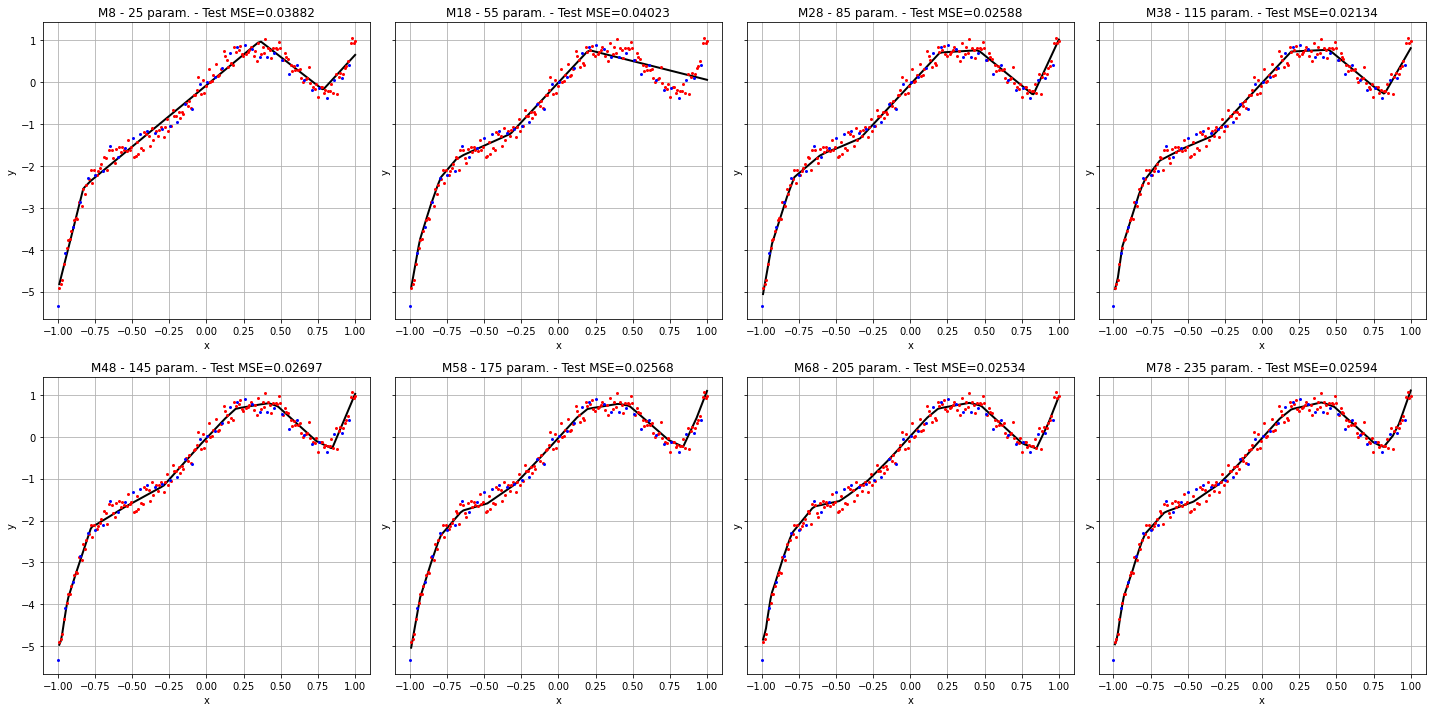

In [29]:
nmodels = 8

statsN = dict()
statsN['Nparam']=[]
statsN['Loss']=[]
statsN['Test_MSE']=[]
statsN['Curves']=[]

ncols = 4
nrows = round(nmodels // ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), sharey=True)
axes_list = [item for sublist in axes for item in sublist] 

fig.subplots_adjust(hspace=0.5)

for nn in range(0,nmodels):
    print(f'Model {nn+1}')
    counter = 1
    best_loss = 1
    while counter<=5:
        tf.keras.backend.clear_session()
        seed = np.random.randint(0,1e8)
        tf.random.set_seed(seed)    

        n = 10*nn + 8

        model = tf.keras.Sequential([
                    tf.keras.layers.Dense(n, activation='relu', name='fc1', input_dim=1, 
                                          kernel_initializer = ini,
                                          bias_initializer=ini_bias1),
                    tf.keras.layers.Dense(1, activation='linear', name='out', 
                                          kernel_initializer = ini,
                                          bias_initializer=ini_bias1),
                    ])

        model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=['mse'])

        history = model.fit(train_dataset,
                            epochs=(10+nn)*epochs,
                            callbacks=[],
                            verbose=verbose, 
                            shuffle=True)

        final_loss = history.history['loss'][-1]
        print(f'loss =  {final_loss}, seed = {seed}, counter = {counter}')
        
        counter += 1

        if final_loss < best_loss:
            best_loss = final_loss
            y_pred_scaled = model.predict(x_train_scaled)
            y_test_scaled = model.predict(x_test_scaled)

            # Reverse the scaling
            y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
            y_test_pred = scale_y.inverse_transform(y_test_scaled)

            test_MSE = mean_squared_error(y_test,y_test_pred)

            N_param = model.count_params()
            if nn == nmodels-1:
                print('Copy last model')
                model_copyN= tf.keras.models.clone_model(model)
                model_copyN.build((None, 1))
                model_copyN.compile(optimizer=optimizer, loss=loss)
                model_copyN.set_weights(model.get_weights())

    ax = axes_list[nn]
    ax.set_xlabel('x', size=10)
    ax.set_ylabel('y', size=10)
    
    statsN['Nparam'].append(N_param)
    statsN['Loss'].append(best_loss)
    statsN['Test_MSE'].append(test_MSE)
    statsN['Curves'].append(y_plot_pred)

    s = 'M'+ str(n) + ' - ' + str(N_param) + ' param. - Test MSE=' + "{:.5f}".format(test_MSE)
    ax.set_title(s)
    ax.plot(x_train, y_plot_pred, c ='k', linewidth=2)

    ax.plot(x_train, y_train, label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    
    ax.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    ax.grid()

fig.tight_layout()
fig.savefig(f"{images_dir}/ModelN.png")

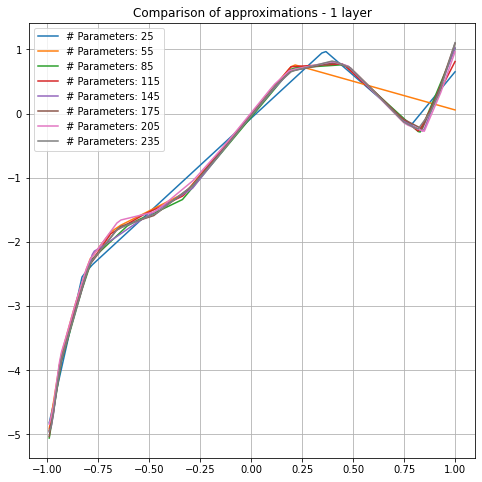

In [32]:
plt.figure(figsize=(8,8))
for i in range(len(statsN['Curves'])):
  plt.plot(x_train,statsN['Curves'][i], label='# Parameters: ' + str(statsN['Nparam'][i]))
plt.grid()
plt.title('Comparison of approximations - 1 layer')
plt.legend()
plt.savefig(f"{images_dir}/CurvesN.png")
plt.show()

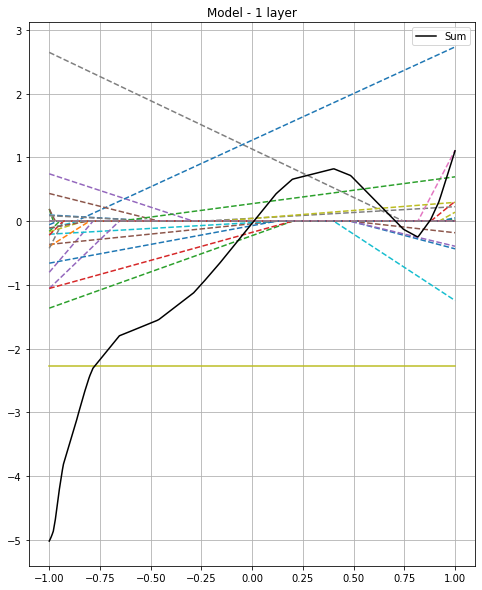

In [33]:
X = np.linspace(-1, 1, num=400).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model_copyN,X,scale_x,scale_y,y_train.min())
plt.figure(figsize=(8,10))
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' )
plt.plot(X,B*np.ones_like(X))    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model - 1 layer')
plt.savefig(f"{images_dir}/Model1NFull_decomp.png")
plt.show()

#### 2 layers

Takes longer to train each model but it not only gives a lower loss for the same number of parameters but also requires much less iterating.

Model 1
loss =  0.003940192982554436, seed = 63008268, counter = 1
loss =  0.0024134963750839233, seed = 61664886, counter = 2
loss =  0.0017520725959911942, seed = 9742126, counter = 3
loss =  0.014801567420363426, seed = 43969398, counter = 4
loss =  0.003981024958193302, seed = 44998434, counter = 5
Model 2
loss =  0.0006733891204930842, seed = 51363955, counter = 1
loss =  0.0021516873966902494, seed = 86185559, counter = 2
loss =  0.0020186440087854862, seed = 28863100, counter = 3
loss =  0.002053478267043829, seed = 26309017, counter = 4
loss =  0.002083899686113, seed = 96365742, counter = 5
Model 3
loss =  0.0018246776890009642, seed = 33565170, counter = 1
loss =  0.0011182015296071768, seed = 17424235, counter = 2
loss =  0.0020589232444763184, seed = 51130990, counter = 3
loss =  0.0019524727249518037, seed = 81850230, counter = 4
loss =  0.000705746584571898, seed = 61352521, counter = 5
Model 4
loss =  0.0006348683964461088, seed = 67014802, counter = 1
loss =  0.00054453

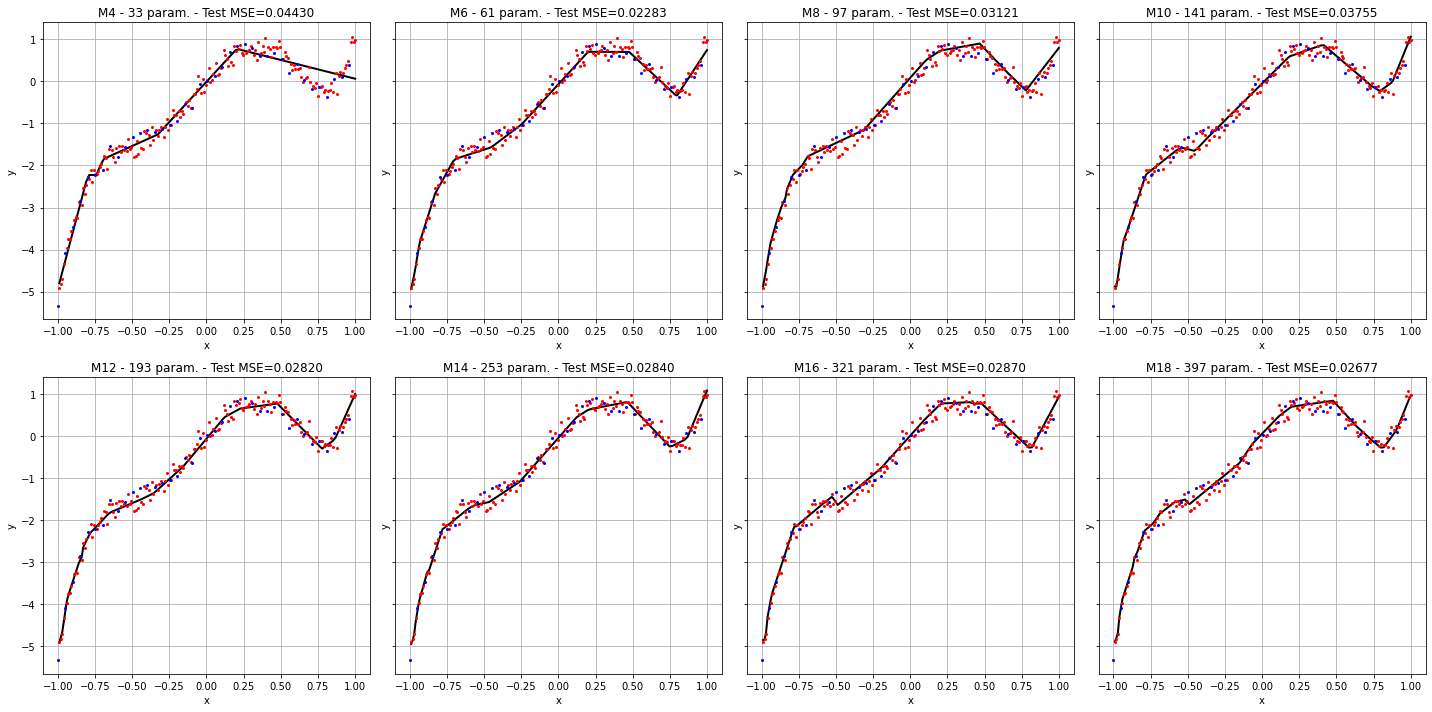

In [34]:
nmodels = 8

stats2N = dict()
stats2N['Nparam']=[]
stats2N['Loss']=[]
stats2N['Test_MSE']=[]
stats2N['Curves']=[]

ncols = 4
nrows = round(nmodels // ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), sharey=True)
axes_list = [item for sublist in axes for item in sublist] 

fig.subplots_adjust(hspace=0.5)

for nn in range(0,nmodels):
    print(f'Model {nn+1}')
    counter = 1
    best_loss = 1
    while counter<=5:
        tf.keras.backend.clear_session()
        seed = np.random.randint(0,1e8)
        tf.random.set_seed(seed)    

        n = 2*nn+4

        model = tf.keras.Sequential([
                    tf.keras.layers.Dense(n, activation=tf.nn.relu, name='fc1', input_dim=1, 
                                          kernel_initializer = ini,
                                          bias_initializer=ini_bias1),
                    tf.keras.layers.Dense(n, activation=tf.nn.relu, name='fc2', input_dim=n,  
                                          kernel_initializer = ini,
                                          bias_initializer=ini_bias1),
                    tf.keras.layers.Dense(1, activation='linear', name='out', input_dim=n,
                                          kernel_initializer = ini,
                                          bias_initializer=ini_bias1),
                    ])

        model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=['mse'])

        history = model.fit(train_dataset,
                            epochs=(10+nn)*epochs,
                            callbacks=[],
                            verbose=verbose, 
                            shuffle=True)

        final_loss = history.history['loss'][-1]
        print(f'loss =  {final_loss}, seed = {seed}, counter = {counter}')
        
        counter += 1

        if final_loss < best_loss:
            best_loss = final_loss
            y_pred_scaled = model.predict(x_train_scaled)
            y_test_scaled = model.predict(x_test_scaled)

            # Reverse the scaling
            y_plot_pred = scale_y.inverse_transform(y_pred_scaled)
            y_test_pred = scale_y.inverse_transform(y_test_scaled)

            test_MSE = mean_squared_error(y_test,y_test_pred)

            N_param = model.count_params()

            if nn == nmodels-1:
                print('Copy last model')
                model_copy2N= tf.keras.models.clone_model(model)
                model_copy2N.build((None, 1))
                model_copy2N.compile(optimizer=optimizer, loss=loss)
                model_copy2N.set_weights(model.get_weights())

    ax = axes_list[nn]
    ax.set_xlabel('x', size=10)
    ax.set_ylabel('y', size=10)
    
    stats2N['Nparam'].append(N_param)
    stats2N['Loss'].append(best_loss)
    stats2N['Test_MSE'].append(test_MSE)
    stats2N['Curves'].append(y_plot_pred)

    s = 'M'+ str(n) + ' - ' + str(N_param) + ' param. - Test MSE=' + "{:.5f}".format(test_MSE)
    ax.set_title(s)
    ax.plot(x_train, y_plot_pred, c ='k', linewidth=2)

    ax.plot(x_train, y_train, label = 'Train data',color='red', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    
    ax.plot(x_test,y_test,label = 'Test data',color='b', 
                marker='o', linestyle='dashed', linewidth=0, markersize=2)
    ax.grid()

fig.tight_layout()
fig.savefig(f"{images_dir}/Model2N.png")

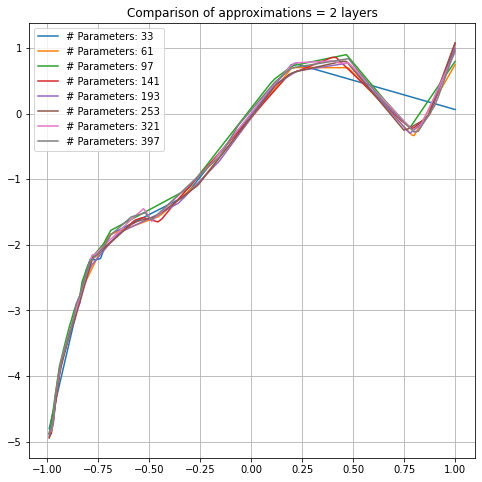

In [35]:
plt.figure(figsize=(8,8))
for i in range(len(stats2N['Curves'])):
    plt.plot(x_train,stats2N['Curves'][i], label='# Parameters: ' + str(stats2N['Nparam'][i]))

plt.grid()
plt.title('Comparison of approximations = 2 layers')
plt.legend()
plt.savefig(f"{images_dir}/Curves2N.png")
plt.show()

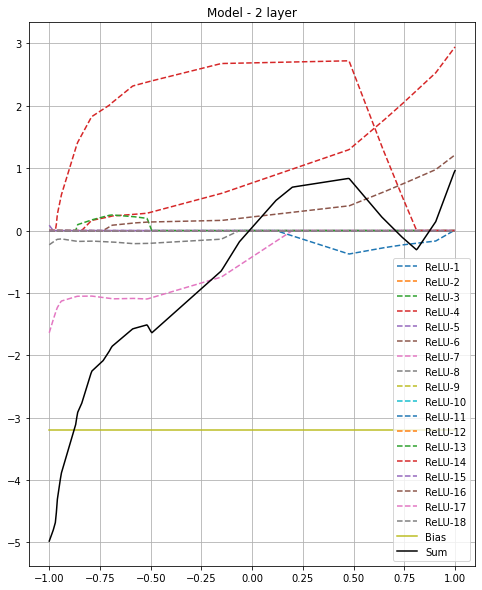

In [38]:
X = np.linspace(-1, 1, num=400).reshape(-1, 1)
Y,B,Z = ReLU_components_plotter(model_copy2N,X,scale_x,scale_y,y_train.min())
plt.figure(figsize=(8,10))
for i in range(Y.shape[0]):
  plt.plot(X,Y[i,:], '--' ,label='ReLU-'+str(i+1))
plt.plot(X,B*np.ones_like(X), label='Bias')    
plt.plot(X,np.transpose(np.sum(Y,axis=0)).reshape(-1,1)+B, label='Sum',color='k')
plt.grid()
plt.legend()
plt.title('Model - 2 layer')
plt.savefig(f"{images_dir}/Model2NFull_decomp.png")
plt.show()

#### Comparing Loss and Test MSE

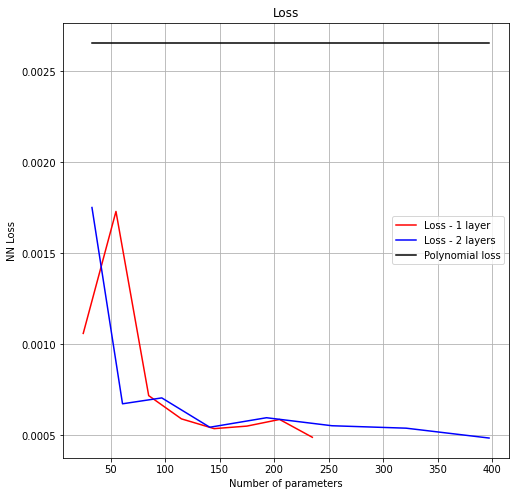

In [42]:
plt.figure(figsize=(8,8))
plt.plot(statsN['Nparam'],statsN['Loss'], label='Loss - 1 layer', color='red')
plt.plot(stats2N['Nparam'],stats2N['Loss'], label='Loss - 2 layers', color='blue')
plt.plot(stats2N['Nparam'],0.002658*np.ones_like(stats2N['Nparam']),label='Polynomial loss', color='black')
plt.xlabel('Number of parameters')
plt.ylabel('NN Loss')
plt.legend()
plt.grid()
plt.title('Loss')
plt.savefig(f"{images_dir}/Loss_comp.png")
plt.show()

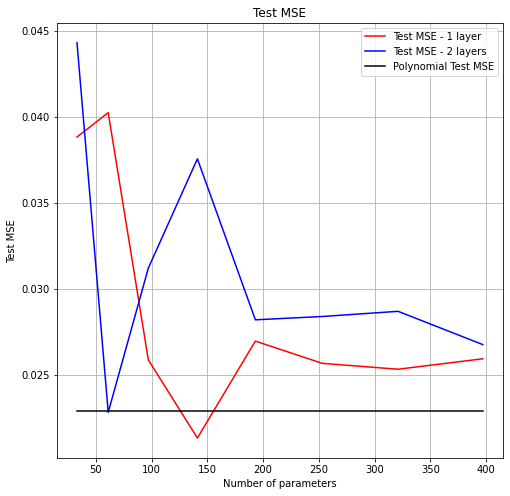

In [41]:
plt.figure(figsize=(8,8))
plt.plot(stats2N['Nparam'],statsN['Test_MSE'], label='Test MSE - 1 layer', color='red')
plt.plot(stats2N['Nparam'],stats2N['Test_MSE'], label='Test MSE - 2 layers', color='blue')
plt.plot(stats2N['Nparam'],0.02293*np.ones_like(stats2N['Nparam']),label='Polynomial Test MSE', color='black')
plt.xlabel('Number of parameters')
plt.ylabel('Test MSE')
plt.legend()
plt.grid()
plt.title('Test MSE')
plt.savefig(f"{images_dir}/TestMSE_comp.png")
plt.show()